In [ ]:
import sys
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path= "/content/drive/MyDrive/bsp final project/ECG measures data"

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

main_path = "/content/drive/MyDrive/bsp final project/ECG measures data/aymen"

#once we have the main path, we'll select each subject/ each measurement (different timing)
#just to bring back:
# each data recorded would have three main parts:
#name 1 - baseline
#name 2 - post isometric
#name 3 - isometric rest
#name 4 - post isotonic
#name 5 - isotonic rest

#and in each folder of data - record it will be three documetns (at least most of them)
# - high fidelity -- we will use this one as it is the best quality data
# - standard view
# - temporary buffer


In [ ]:
pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 14.9 MB/s eta 0:00:00


So one of the hassles we needed to deal with was mixing samples. But, as we also took blood pressure measure, we are going to use it as guidance for defining and specificating each data to their respective subject. We propose analyzing the each "wrong" data and extract the hear rate, and compare to the expected result that we had registered on the blood pressure data.  

In [ ]:
def plot_ecg(ecg_cleaned, sampling_rate):

    plt.figure(figsize=(12, 8))

    # Crear eje de tiempo en segundos
    time_axis = np.arange(len(ecg_cleaned)) / sampling_rate

    plt.plot(time_axis, ecg_cleaned, label="ECG Limpio", color='#1f77b4')

    # Convertir índices de picos a tiempo
    plt.title(f"Señal ECG")
    plt.xlabel("Tiempo (segundos)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import neurokit2 as nk

for checking the viability of the recordings

In [ ]:
# Configuración de gráficos para que se vean grandes y claros
plt.rcParams['figure.figsize'] = [15, 5]

def paso_1_inspeccion_visual(ecg_signal, fs, titulo="Señal Cruda"):
    """
    Objetivo: Detectar saturación, cortes, desconexiones y artefactos obvios.
    """
    t = np.arange(len(ecg_signal)) / fs

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'width_ratios': [3, 1]})

    # Gráfico de tiempo
    ax1.plot(t, ecg_signal, color='black', lw=0.7)
    ax1.set_title(f"{titulo} - Vista Temporal")
    ax1.set_xlabel("Tiempo (s)")
    ax1.set_ylabel("Amplitud")
    ax1.grid(True, alpha=0.3)

    # Histograma de valores (Para ver saturación)
    ax2.hist(ecg_signal, bins=50, color='gray', orientation='horizontal')
    ax2.set_title("Distribución de Valores")
    ax2.set_xlabel("Frecuencia")

    plt.tight_layout()
    plt.show()

    # Chequeo rápido de "Railing" (Saturación)
    max_val = np.max(ecg_signal)
    min_val = np.min(ecg_signal)
    if np.sum(ecg_signal == max_val) > len(ecg_signal) * 0.05:
        print("⚠️ ALERTA: La señal parece estar SATURADA (techo).")

def paso_2_analisis_espectral(ecg_signal, fs):
    """
    Objetivo: Ver si existe contenido de frecuencia cardíaca o solo ruido.
    El QRS suele estar entre 10Hz y 30Hz. El ruido de red en 50Hz o 60Hz.
    """
    # Calcular Densidad Espectral de Potencia (Welch)
    f, Pxx = signal.welch(ecg_signal, fs, nperseg=1024)

    plt.figure()
    plt.semilogy(f, Pxx)
    plt.title("Paso 2: Análisis de Frecuencia (Espectro de Potencia)")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Potencia (dB)")
    plt.xlim(0, 100) # Nos interesa ver hasta 100Hz

    # Marcar zonas de interés
    plt.axvspan(0.5, 3, color='green', alpha=0.1, label='Rango Latido (BPM)')
    plt.axvspan(5, 30, color='blue', alpha=0.1, label='Energía QRS')
    plt.axvline(50, color='red', linestyle='--', label='Ruido Red (50Hz)')
    plt.axvline(60, color='red', linestyle='--', label='Ruido Red (60Hz)')

    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.show()
    print("💡 PISTA: Si ves un pico gigante en 50/60Hz y nada en la zona azul, es solo ruido eléctrico.")

def paso_3_limpieza_comparativa(ecg_signal, fs):
    """
    Objetivo: Limpiar la señal y verificar que no hayamos destruido la información.
    """
    # Limpieza estándar con NeuroKit
    ecg_clean = nk.ecg_clean(ecg_signal, sampling_rate=fs, method="neurokit")

    # Graficar superpuestos
    t = np.arange(len(ecg_signal)) / fs

    plt.figure()
    plt.plot(t, ecg_signal, color='lightgray', label='Original (Ruidosa)')
    plt.plot(t, ecg_clean, color='teal', lw=1.5, label='Limpia (NeuroKit)')
    plt.title("Paso 3: Comparación Antes vs. Después de Limpieza")
    plt.legend()
    plt.xlim(0, 10) # Hacemos zoom a los primeros 10 segundos
    plt.show()

    return ecg_clean

def paso_4_detectar_y_validar(ecg_clean, fs):
    """
    Objetivo: Intentar detectar picos y mostrar DÓNDE falló si lo hizo.
    """
    try:
        # Intentamos detectar picos
        _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs, correct_artifacts=True)
        r_peaks = info["ECG_R_Peaks"]

        # Visualización Forense
        plt.figure()
        t = np.arange(len(ecg_clean)) / fs

        plt.plot(t, ecg_clean, color='teal')

        # Marcar los picos encontrados
        plt.plot(t[r_peaks], ecg_clean[r_peaks], "ro", label="Picos Detectados")

        # Calcular HR instantáneo para ver estabilidad
        if len(r_peaks) > 1:
            rr_intervals = np.diff(r_peaks) / fs
            hr_inst = 60 / rr_intervals
            hr_mean = np.mean(hr_inst)
            plt.title(f"Paso 4: Detección Exitosa - HR Promedio: {hr_mean:.1f} BPM")
        else:
            plt.title("Paso 4: Fallo - No se detectaron suficientes picos")

        plt.legend()
        plt.show()

        if len(r_peaks) < 5:
            print("❌ DIAGNÓSTICO: Muy pocos picos detectados. Posiblemente la amplitud es muy baja o el ruido tapa los QRS.")
        else:
            print("✅ DIAGNÓSTICO: Detección técnicamente posible.")

    except Exception as e:
        print(f"❌ ERROR CRÍTICO EN DETECCIÓN: {e}")
        # Si falla, graficamos la señal para ver por qué
        plt.plot(ecg_clean)
        plt.title("Señal que provocó el error")
        plt.show()

In [ ]:
#load data
file_path = "/content/drive/MyDrive/bsp final project/ECG measures data/Subject_06/3_Recovery_Isometric/ecg.dat"

with open(file_path, 'rb') as f:
    raw_binary = f.read()

# Convert to numpy array
ecg_signal = np.frombuffer(raw_binary, dtype=np.int16)

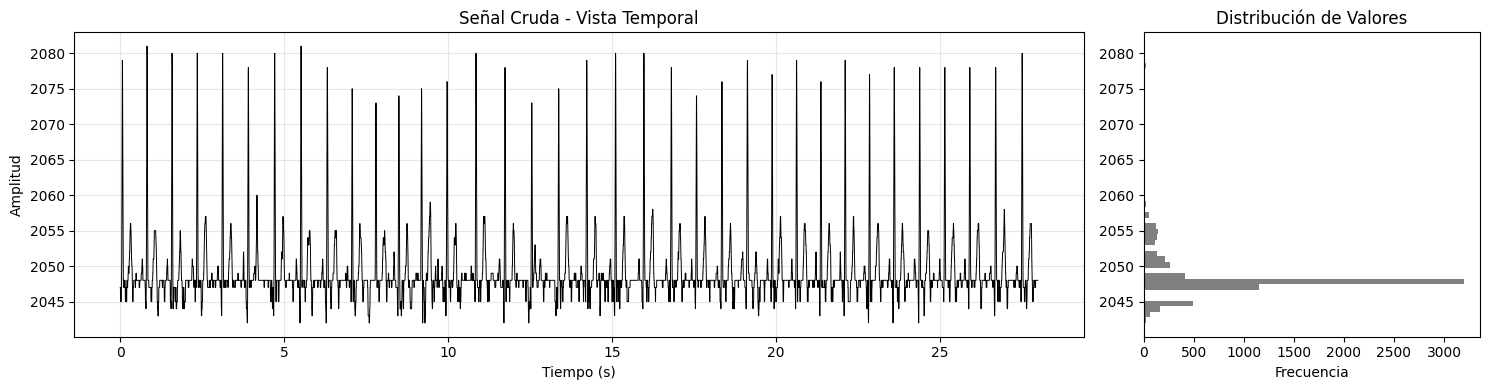

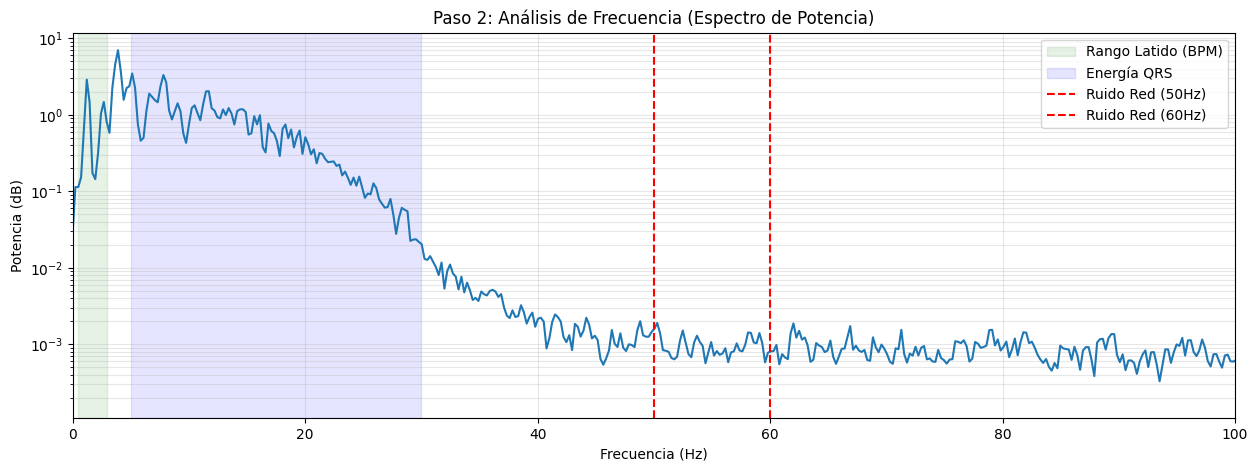

💡 PISTA: Si ves un pico gigante en 50/60Hz y nada en la zona azul, es solo ruido eléctrico.


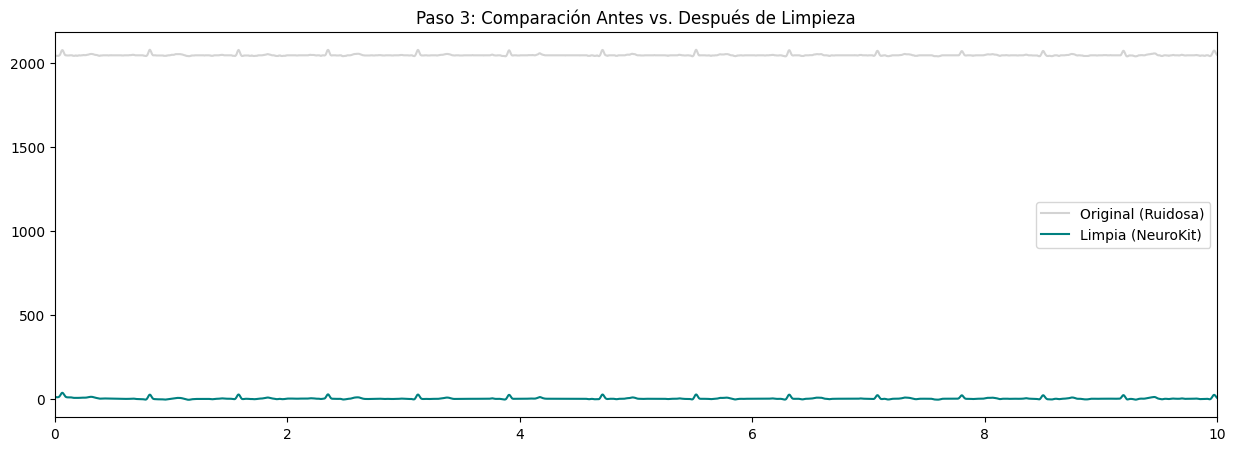

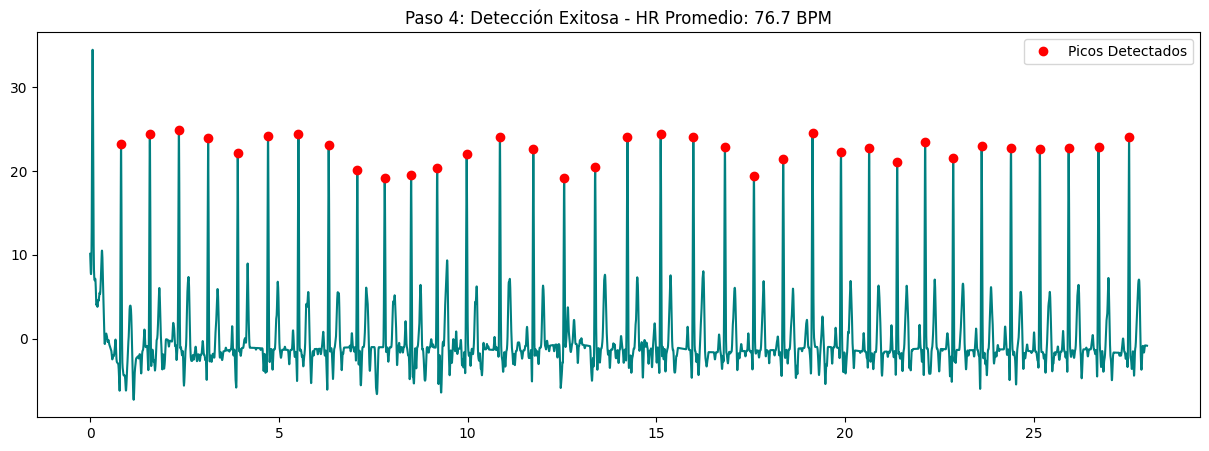

✅ DIAGNÓSTICO: Detección técnicamente posible.


In [ ]:
# --- EJECUCIÓN DEL PIPELINE (Ejemplo) ---
# Sustituye 'mi_senal_ecg' por tu array de datos real
# mi_senal_ecg = np.array([...])

# 0. Recorte preventivo (Como hablamos antes, quitar el "golpe" inicial)
fs = 250 # ¡Asegúrate de que este valor es correcto!
mi_senal_recortada = ecg_signal[2*fs:] # Quitamos los primeros 2 segundos

# Ejecutar pasos
paso_1_inspeccion_visual(mi_senal_recortada, fs)
paso_2_analisis_espectral(mi_senal_recortada, fs)
senal_limpia = paso_3_limpieza_comparativa(mi_senal_recortada, fs)
paso_4_detectar_y_validar(senal_limpia, 250)